In [1]:
from sympy import diff, lambdify, symbols, sqrt, cos
import numpy as np
import rebound
from scipy.integrate import odeint
from sympy import init_printing
init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import FloatSlider

In [2]:
m, m1, M1, mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, P1, P2, p1, p2, alpha = symbols("m, m1, M1, mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, P1, P2, p1, p2, alpha")
J1, J2, Gamma1, Gamma2, phi1, phi2 = symbols("J1, J2, Gamma1, Gamma2, phi1, phi2")
f27 = -0.46 - 0.802*m
f31 = 0.87 + 0.802*m
H = -mu1/(2.*Lambda1**2) - mu2/(2.*Lambda2**2) - m1/M1*mu2/Lambda2**2*(f27*sqrt(2.*P1/Lambda1)*cos((m+1)*lambda2 - m*lambda1 + p1) + f31*sqrt(2.*P2/Lambda2)*cos((m+1)*lambda2 - m*lambda1 + p2))
H2 = H
H2 = H2.subs(P1, Gamma1)
H2 = H2.subs(P2, Gamma2)
H2 = H2.subs((m+1)*lambda2 - m*lambda1 + p1, phi1)
H2 = H2.subs((m+1)*lambda2 - m*lambda1 + p2, phi2)
H2 = H2.subs(Lambda1, J1 - m*(Gamma1 + Gamma2))
H2 = H2.subs(Lambda2, J2 + (m+1)*(Gamma1 + Gamma2))

var = (mu1, J1, m, mu2, J2, m1, M1, phi1, phi2, Gamma1, Gamma2)
Hamiltonian = lambdify(var, H2, 'numpy')

def mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return Mint*self.m/(Mint+self.m)

def Mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return (Mint+self.m)/Mint*self._sim.contents.particles[0].m

def Lambda(self):
    return self.mjac*np.sqrt(self._sim.contents.G*self.Mjac*self.a)

def Gamma(self):
    return self.Lambda*(1.-np.sqrt(1.-self.e**2))

def J(self):
    if self.hash == 1:
        return self.Lambda + m*(self._sim.contents.particles[1].Gamma + self._sim.contents.particles[1].Gamma)
    if self.hash == 2:
        return self.Lambda - (m+1)*(self._sim.contents.particles[1].Gamma + self._sim.contents.particles[1].Gamma)
    
def mu(self):
    return self._sim.contents.G**2*self.Mjac**2*self.mjac**3

def phi(self):
    return (m+1)*self._sim.contents.particles[2].l - m*self._sim.contents.particles[1].l - self.pomega

rebound.Particle.mjac = property(mjac)
rebound.Particle.Mjac = property(Mjac)
rebound.Particle.Lambda = property(Lambda)
rebound.Particle.Gamma = property(Gamma)
rebound.Particle.J = property(J)
rebound.Particle.mu = property(mu)
rebound.Particle.phi = property(phi)

In [27]:
m=2. # m-value for resonance, i.e. resonance is m+1:m
e0 = 1.e-3 # initial eccentricity of planets
Norbits = 10000 # number of inner planet orbits to integrate for
Nout = 10000 # number of output points

In [49]:
sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=1.e-4, e=e0, P=1.)
sim.add(m=1.e-4, e=e0, P=(m+1)/m)
sim.move_to_com()
ps = sim.particles
ps[1].hash = 1
ps[2].hash = 2

H0 = Hamiltonian(ps[1].mu, ps[1].J, m, ps[2].mu, ps[2].J, ps[1].mjac, ps[1].Mjac, ps[1].phi, ps[2].phi, ps[1].Gamma, ps[2].Gamma)

tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout, endpoint=False)

Herr, H = np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    H[i] = Hamiltonian(ps[1].mu, ps[1].J, m, ps[2].mu, ps[2].J, ps[1].mjac, ps[1].Mjac, ps[1].phi, ps[2].phi, ps[1].Gamma, ps[2].Gamma)
    Herr[i] = np.abs((H[i] - H0)/H0)

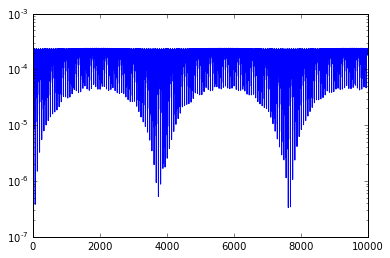

In [53]:
fig, ax = plt.subplots()
ax.plot(times, Herr)
ax.set_yscale('log')

In [52]:
H

array([-0.00348014, -0.00348087, -0.00348087, ..., -0.0034809 ,
       -0.00348094, -0.00348078])

nyq = 0.4999999999999999


/Users/dtamayo/miniconda2/envs/p3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


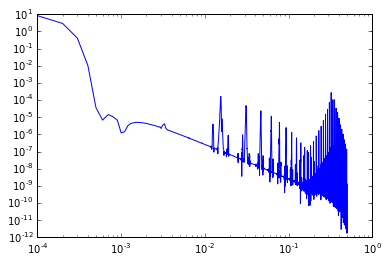

In [35]:
from scipy.fftpack import fft

T = tmax/Nout # sample spacing
nyq= 1./(2.*T) # Nyquist freq
print("nyq = {0}".format(nyq))
from scipy.signal import kaiser
w = kaiser(Nout, 14)
yf = fft(H*w)
xf = np.linspace(0., nyq, Nout/2)
fig, ax = plt.subplots()
ax.plot(xf[1:], np.abs(yf[1:Nout/2]))
ax.set_yscale('log')
ax.set_xscale('log')

In [58]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def bandpass(lowcut, highcut):
    fs = Nout/tmax
    Havg = butter_bandpass_filter(H, lowcut, highcut, fs)
    Herravg = np.abs((Havg-Havg[0])/Havg[0])
    fig, ax = plt.subplots()
    #ax.plot(times, Hunscaled+4.071e-3)
    ax.plot(times[4500:], Havg[4500:])
    fig.show()
    #ax.plot(times, Hints)
    ax.set_yscale('log')

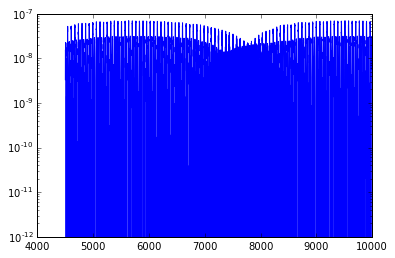

In [61]:
widgets.interact(bandpass, lowcut=(0,nyq, 0.01), highcut=(0,nyq,0.01))

In [42]:
fs = Nout/tmax
lowcut=0.01
highcut=0.05
Havg = butter_bandpass_filter(H, lowcut, highcut, fs)
Herravg = np.abs((Havg-H0)/H0)

In [43]:
Herravg

array([ 0.9999786 ,  0.99978397,  0.99891946, ...,  1.00001913,
        1.00001871,  1.00001824])

In [44]:
Havg

array([ -7.44615695e-08,  -7.51801549e-07,  -3.76041636e-06, ...,
         6.65869953e-08,   6.50977498e-08,   6.34715557e-08])

In [45]:
H0